In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply
import cv2
import numpy as np
from pathlib import Path

# Run 1 InceptionV3

## Load The Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'aptos2019' dataset.
Path to dataset files: /kaggle/input/aptos2019


In [3]:
os.listdir(path)

['val_images',
 'train_images',
 'valid.csv',
 'test.csv',
 'train_1.csv',
 'test_images']

In [4]:
unbalanced_data_path = path+'/train_images/train_images'

In [5]:
y_true = pd.read_csv(path+'/train_1.csv')
y_true['id_code'] = y_true['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png

In [6]:
y_true['diagnosis']=y_true['diagnosis'].astype(str)
y_true.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


## Image Prepro


In [7]:
IM_SIZE=600

In [8]:
!rm -rf percent_train

In [9]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.08, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.1),
        ]
    )

In [10]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '0': 1434, '3': 154}
Class 0: No augmentation needed (multiplier=1.0x)
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 4394 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '1': 600, '0': 1434, '4': 936}


In [11]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []

    # Get absolute path for the augmented directory
    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():
        # balanced_df['id_code'] contains filenames WITHOUT .png extension
        if row['is_augmented']:
            # Augmented files were saved as {id_code}_aug_X.png
            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:
            # Original files are {id_code}.png
            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path)) # Ensure it's a string
        labels.append(row['diagnosis'])

    return paths, labels

# Load balanced dataset

# balanced_df = pd.read_csv(f"{balanced_output_dir}/labels.csv")
# paths, labels = get_combined_paths(balanced_df, train_dir, f"{balanced_output_dir}")

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=image/255.0
  return image

In [12]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png
test_images=path+'/test_images/test_images/' # Corrected path for nested test images

In [ ]:
val_df

,id_code,diagnosis
0,e4dcca36ceb4,0
1,e4e343eaae2a,2
2,e4f12411fd85,4
3,e50b0174690d,0
4,e5197d77ec68,0
...,...,...
361,ffa47f6a7bf4,2
362,ffc04fed30e6,0
363,ffcf7b45f213,2
364,ffd97f8cd5aa,0


In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance

    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
def Graham_Color(image, sigmaX=50):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IM_SIZE, IM_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image

In [ ]:
train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})

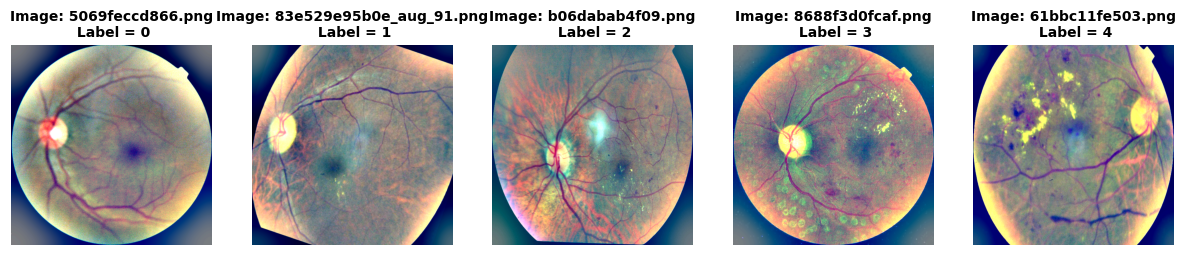

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    # The 'id_code' column already contains the full path including the extension.
    # So, we can directly use image_name as the path.
    image_path = image_name

    X = cv2.imread(image_path)
    X=Graham_Color(X)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {os.path.basename(image_name)}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## DataGen

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=Graham_Color)

val_datagen=ImageDataGenerator(preprocessing_function=Graham_Color)

train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})
train_df['diagnosis'] = train_df['diagnosis'].astype(str)

train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = None, # x_col now contains full paths
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=4,
                                                    class_mode='categorical',shuffle=True)

# For validation data, create full paths in a new column
val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = val_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path', # Use the full path
                                                  y_col='diagnosis',
                                                  directory = None, # No directory needed, paths are full
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=4,
                                                  class_mode='categorical',shuffle=False)

Found 4394 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


## Add Weights

In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.6128312412831242), '1': np.float64(1.4646666666666666), '2': np.float64(1.0876237623762377), '3': np.float64(1.4266233766233767), '4': np.float64(0.9388888888888889)}


## Load InceptionV3 Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])


In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True,mode='max')
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  factor=0.5,
                                                                patience=2,
                                                                verbose=1,
                                                                mode='auto',
                                                                epsilon=0.001)

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,592,869 (86.18 MB)

 Trainable params: 22,558,437 (86.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it,rlr])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1251s 1s/step - accuracy: 0.4879 - loss: 1.2788 - val_accuracy: 0.7650 - val_loss: 0.6280 - learning_rate: 1.0000e-05
Epoch 2/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1074s 977ms/step - accuracy: 0.6844 - loss: 0.8114 - val_accuracy: 0.8115 - val_loss: 0.5341 - learning_rate: 1.0000e-05
Epoch 3/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1070s 974ms/step - accuracy: 0.7598 - loss: 0.6269 - val_accuracy: 0.8251 - val_loss: 0.5097 - learning_rate: 1.0000e-05
Epoch 4/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1065s 969ms/step - accuracy: 0.8228 - loss: 0.4924 - val_accuracy: 0.8224 - val_loss: 0.5370 - learning_rate: 1.0000e-05
Epoch 5/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1092s 960ms/step - accuracy: 0.8720 - loss: 0.3808 - val_accuracy: 0.8251 - val_loss: 0.5942 - learning_rate: 1.0000e-05
Epoch 6/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1057s 962ms/step - accuracy: 0.9179 - loss: 0.2595 - val_accuracy: 0.7978 - val_loss: 0.6581 - learning_rate: 1.0000e-05
Epoch 7/20
1099/1099 ━━━━

In [ ]:
model=tf.keras.models.load_model('/content/inV3best_with_weights (1).keras')
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=(1e-5)/2),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it,rlr],initial_epoch=7)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 8/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1263s 1s/step - accuracy: 0.8979 - loss: 0.2849 - val_accuracy: 0.8306 - val_loss: 0.6802 - learning_rate: 5.0000e-06
Epoch 9/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1092s 994ms/step - accuracy: 0.9388 - loss: 0.1914 - val_accuracy: 0.8251 - val_loss: 0.6938 - learning_rate: 5.0000e-06
Epoch 10/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1098s 1000ms/step - accuracy: 0.9533 - loss: 0.1692 - val_accuracy: 0.8169 - val_loss: 0.6755 - learning_rate: 5.0000e-06
Epoch 11/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1088s 990ms/step - accuracy: 0.9615 - loss: 0.1306 - val_accuracy: 0.8087 - val_loss: 0.7266 - learning_rate: 5.0000e-06
Epoch 12/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.9626 - loss: 0.1252
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1084s 986ms/step - accuracy: 0.9626 - loss: 0.1252 - val_accuracy: 0.8251 - val_loss: 0.7425 - learning_rate: 5.0000e-06


In [ ]:
model=tf.keras.models.load_model('/content/inV3best_with_weights.keras')
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=(1e-5)/3),loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it,rlr],initial_epoch=12)

Epoch 13/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1250s 1s/step - accuracy: 0.9709 - loss: 0.1101 - val_accuracy: 0.8224 - val_loss: 0.7898 - learning_rate: 3.3333e-06
Epoch 14/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1176s 1s/step - accuracy: 0.9706 - loss: 0.1064 - val_accuracy: 0.8279 - val_loss: 0.7249 - learning_rate: 3.3333e-06
Epoch 15/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1137s 1s/step - accuracy: 0.9742 - loss: 0.0907 - val_accuracy: 0.8279 - val_loss: 0.7473 - learning_rate: 3.3333e-06
Epoch 16/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.9705 - loss: 0.0832
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.6666666624587378e-06.
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1109s 1s/step - accuracy: 0.9705 - loss: 0.0832 - val_accuracy: 0.8279 - val_loss: 0.7393 - learning_rate: 3.3333e-06
Epoch 17/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1124s 1s/step - accuracy: 0.9754 - loss: 0.0761 - val_accuracy: 0.8306 - val_loss: 0.7672 - learning_rate: 1.6667e-06
Epoch 18/20
1099/1099 ━━━━━━━━━━━━━━━━

## Model Evaluation

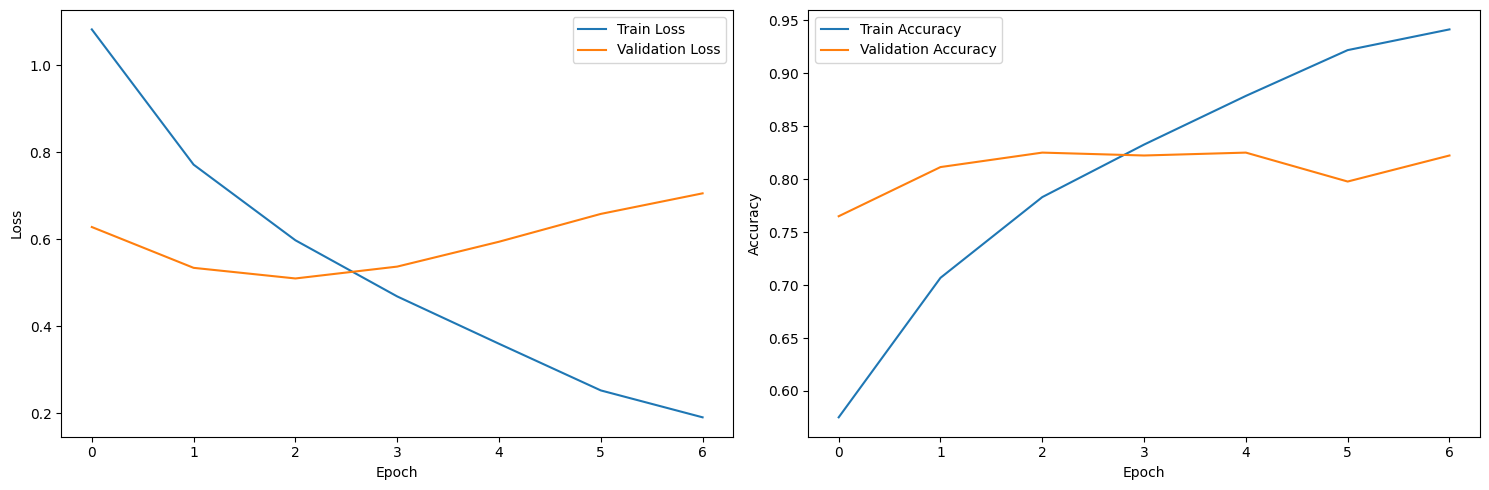

In [ ]:
ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
predictions=model.predict(val_gen)
predictions=np.argmax(predictions,axis=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step


<Axes: >

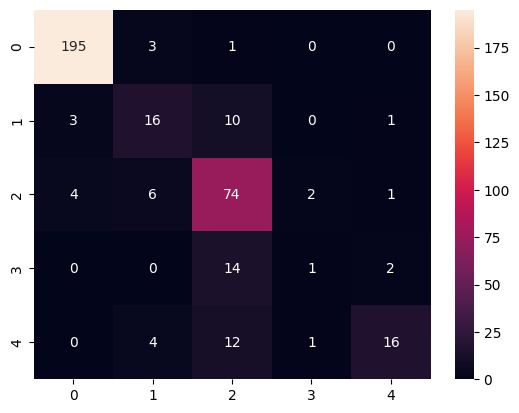

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(val_gen.classes,predictions),annot=True,fmt='d')

In [ ]:
print(classification_report(val_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       199
           1       0.55      0.53      0.54        30
           2       0.67      0.85      0.75        87
           3       0.25      0.06      0.10        17
           4       0.80      0.48      0.60        33

    accuracy                           0.83       366
   macro avg       0.65      0.58      0.59       366
weighted avg       0.81      0.83      0.81       366



In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (512, 512, 3)
Sample image processed shape for model input: (1, 512, 512, 3)
Sample label: [0. 1. 0. 0. 0.]


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Raw attention map shape: (14, 14)
Resized attention map shape: (512, 512)
Model prediction for sample image: [[0.02353958 0.66434807 0.2707106  0.0171863  0.02421547]]


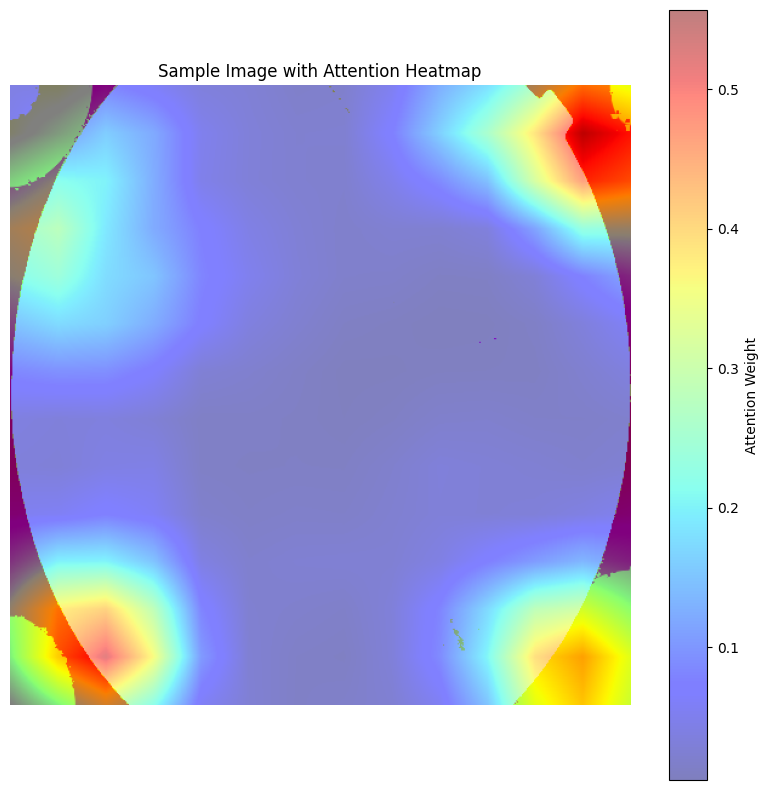

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# Retrain InV3 with IM_size=512->83% acc


## Augmentation

In [ ]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [ ]:
IM_SIZE=512

In [ ]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.8, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.3),
        ]
    )

In [ ]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '0': 1434, '3': 154}
Class 0: No augmentation needed (multiplier=1.0x)
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 4394 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '1': 600, '0': 1434, '4': 936}


In [ ]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []


    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():

        if row['is_augmented']:

            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:

            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path))
        labels.append(row['diagnosis'])

    return paths, labels

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=apply_clahe(image)
  image=image/255.0
  return image

In [ ]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False)
test_images=path+'/test_images/test_images/'

## Data Sample

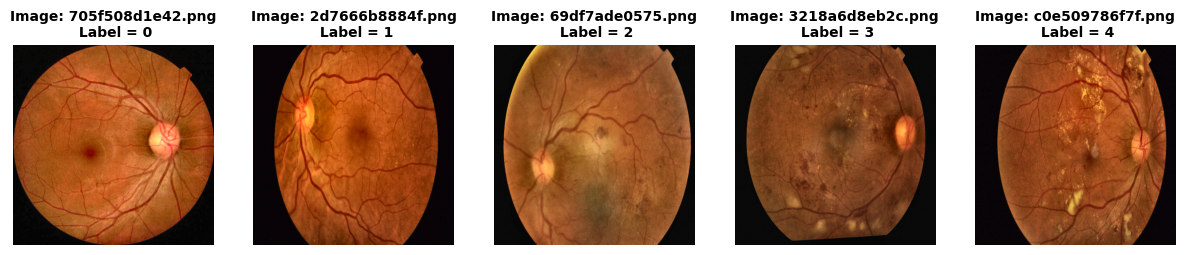

In [ ]:
train_df = pd.read_csv(path+'/train_1.csv')
train_df['id_code'] = train_df['id_code'].map(lambda x: x + '.png' if not x.endswith('.png') else x)


fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = image_resize(cv2.imread(f"{unbalanced_data_path}/{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Make Train-Test Dataset

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)

train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})
train_df['diagnosis'] = train_df['diagnosis'].astype(str)

train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=8,
                                                    class_mode='categorical')


val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = train_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path',
                                                  y_col='diagnosis',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=8,
                                                  class_mode='categorical',shuffle=False)

Found 4394 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


In [ ]:
classes = np.unique(train_df['diagnosis'])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df['diagnosis'].values)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}


print(class_weight_dict)

{'0': np.float64(0.6128312412831242), '1': np.float64(1.4646666666666666), '2': np.float64(1.0876237623762377), '3': np.float64(1.4266233766233767), '4': np.float64(0.9388888888888889)}


## Load The New Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

##Train The New Model

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 606s 4s/step - accuracy: 0.5310 - loss: 1.2858 - val_accuracy: 0.5410 - val_loss: 1.1564
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.6876 - loss: 0.7915 - val_accuracy: 0.5574 - val_loss: 1.1016
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.8193 - loss: 0.5457 - val_accuracy: 0.4290 - val_loss: 1.3785
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.8475 - loss: 0.4372 - val_accuracy: 0.5984 - val_loss: 1.0176
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9030 - loss: 0.3117 - val_accuracy: 0.7486 - val_loss: 0.6639
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 502s 4s/step - accuracy: 0.9442 - loss: 0.2096 - val_accuracy: 0.8087 - val_loss: 0.5245
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - accuracy: 0.9678 - loss: 0.1339 - val_accuracy: 0.8306 - val_loss: 0.5296
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.9786 - loss: 0.0931 - val_accu

## Evaluation

In [ ]:
model.evaluate(val_gen)

12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8421 - loss: 0.5850


[0.5403921604156494, 0.8387978076934814]

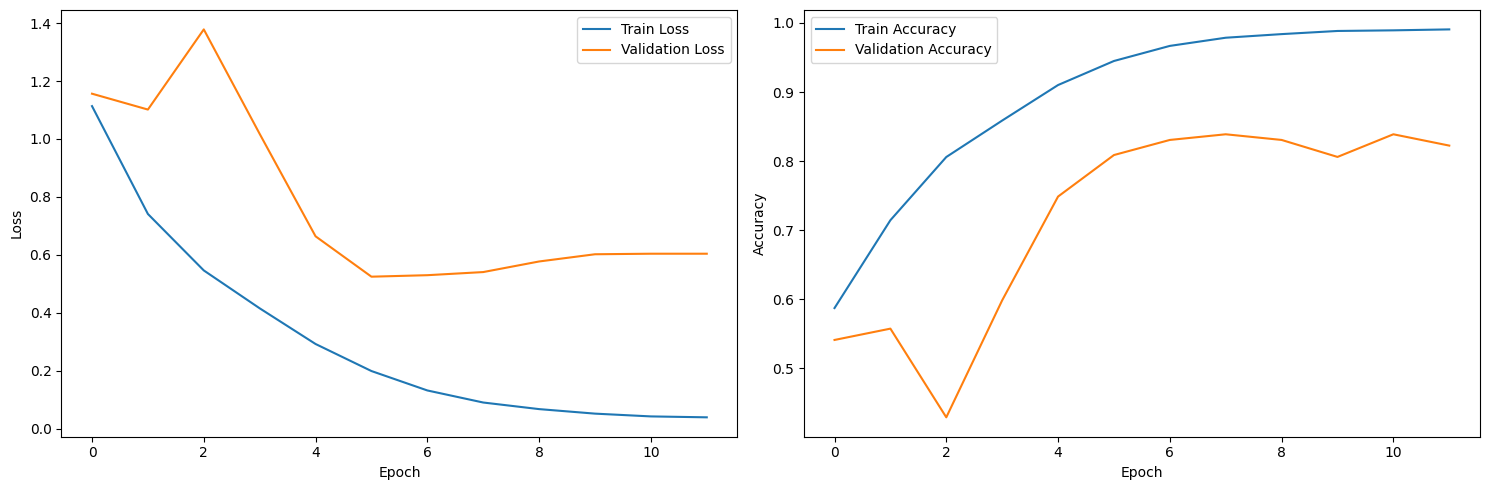

In [ ]:
ig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history.history['loss'],label='Train Loss')
axes[0].plot(history.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (512, 512, 3)
Sample image processed shape for model input: (1, 512, 512, 3)
Sample label: [0. 0. 0. 0. 1.]


In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Raw attention map shape: (14, 14)
Resized attention map shape: (512, 512)
Model prediction for sample image: [[0.0059366  0.07687273 0.731426   0.01903035 0.16673428]]


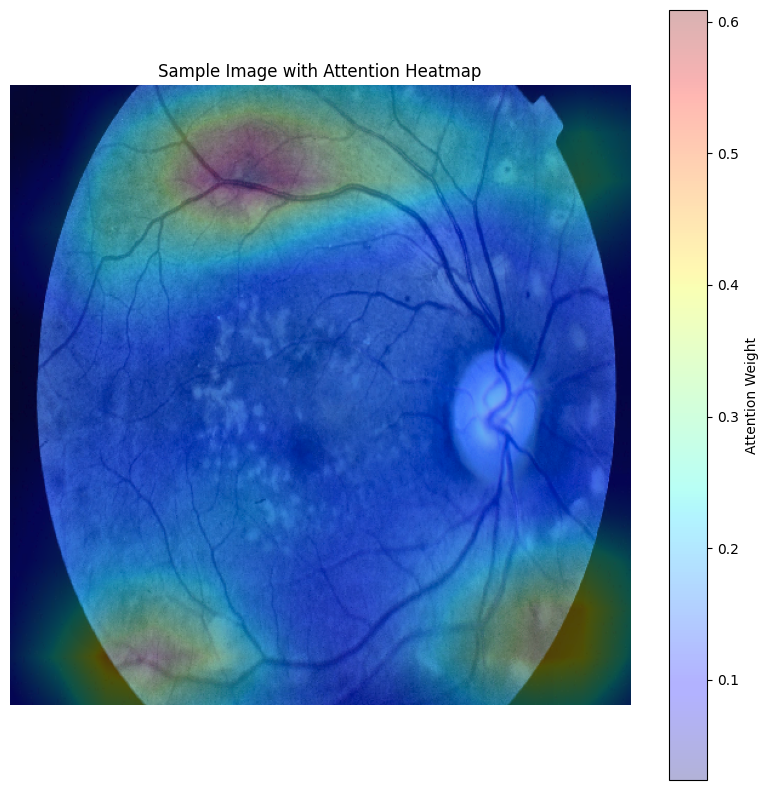

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

## Report

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

def evaluate_and_plot_confusion_matrix(model, df, image_directory, image_resize_func):
    true_labels = []
    predicted_labels = []


    unique_diagnoses = sorted(df['diagnosis'].unique().tolist())
    class_name_to_int = {str(val): idx for idx, val in enumerate(unique_diagnoses)}

    print(f"Evaluating {len(df)} images...")

    for index, row in df.iterrows():
        img_id = row['id_code']
        true_diagnosis_str = row['diagnosis']


        if 'full_path' in df.columns:
            full_path = row['full_path']
        else:
            full_path = os.path.join(image_directory, f"{img_id}.png")


        img = cv2.imread(full_path)
        if img is None:
            print(f"Warning: Could not load image {full_path}. Skipping.")
            continue


        processed_img = image_resize_func(img)
        processed_img = np.expand_dims(processed_img, axis=0)


        prediction = model.predict(processed_img, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]

        true_labels.append(class_name_to_int[true_diagnosis_str])
        predicted_labels.append(predicted_class)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)


    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=[str(i) for i in sorted(class_name_to_int.values())]))


    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(true_labels, predicted_labels),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in sorted(class_name_to_int.values())],
                yticklabels=[str(i) for i in sorted(class_name_to_int.values())])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

Evaluating 366 images...

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.99      0.79       199
           1       0.17      0.10      0.12        30
           2       0.53      0.21      0.30        87
           3       0.00      0.00      0.00        17
           4       0.45      0.15      0.23        33

    accuracy                           0.61       366
   macro avg       0.36      0.29      0.29       366
weighted avg       0.54      0.61      0.53       366



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


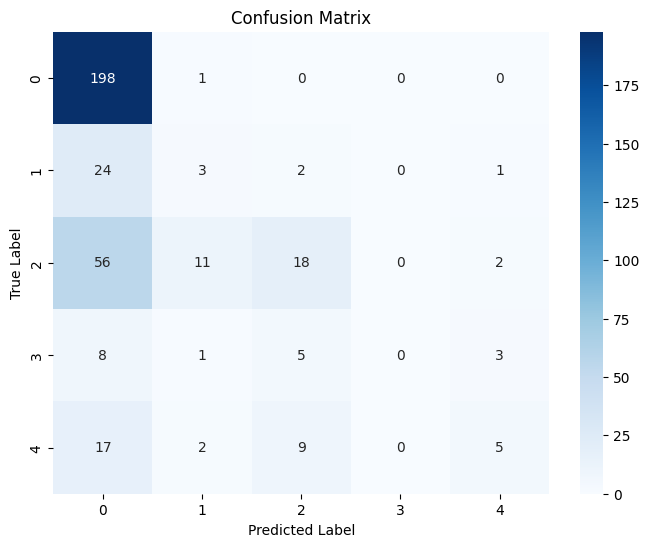

In [ ]:
evaluate_and_plot_confusion_matrix(model, val_df, test_images, image_resize)


## Second Try Invception

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")
base_model.trainable = True

import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Pre-trained InceptionV3 model loaded successfully.


In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')
def schedule_fn(epoch, lr):
    start_lr = 0.0001
    end_lr = 1e-5
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_gen,
                  validation_data=val_gen,
                  epochs=20,
                  class_weight=class_weight_dict,
                  callbacks=[model_checkpoint_callback,early_stop_it,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step - accuracy: 0.6409 - loss: 0.9165 - val_accuracy: 0.7951 - val_loss: 0.5812 - learning_rate: 1.0000e-04
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 522s 948ms/step - accuracy: 0.8159 - loss: 0.5005 - val_accuracy: 0.8087 - val_loss: 0.5266 - learning_rate: 8.9125e-05
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 512s 931ms/step - accuracy: 0.9069 - loss: 0.2690 - val_accuracy: 0.7978 - val_loss: 0.6801 - learning_rate: 7.9433e-05
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 518s 942ms/step - accuracy: 0.9526 - loss: 0.1649 - val_accuracy: 0.7650 - val_loss: 0.8309 - learning_rate: 7.0795e-05
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 518s 942ms/step - accuracy: 0.9609 - loss: 0.1239 - val_accuracy: 0.8279 - val_loss: 0.7818 - learning_rate: 6.3096e-05
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 514s 933ms/step - accuracy: 0.9743 - loss: 0.0894 - val_accuracy: 0.8361 - val_loss: 0.6931 - learning_rate: 5.6234e-05
Epoch 7/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 504

In [ ]:
model=tf.keras.models.load_model('/content/inV3best_with_weights84.keras')
history=model.fit(train_gen,
                  validation_data=val_gen,
                  epochs=20,
                  class_weight=class_weight_dict,
                  callbacks=[model_checkpoint_callback,early_stop_it,lr_scheduler],initial_epoch=12)


ValueError: File not found: filepath=/content/inV3best_with_weights84.keras. Please ensure the file is an accessible `.keras` zip file.

## Evaluation

In [ ]:
model=tf.keras.models.load_model('/content/inV3best_with_weights84.keras')

ValueError: File not found: filepath=/content/inV3best_with_weights84.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.evaluate(val_gen)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

preds_prob=model.predict(val_gen)
preds=np.argmax(preds_prob,axis=1)
true_labels=val_gen.classes
print(classification_report(true_labels,preds))


In [ ]:
sns.heatmap(confusion_matrix(true_labels,preds),annot=True,fmt='d',cmap='Blues')

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# Let'e Use Only The DR Images




In [ ]:
y_true=y_true[y_true['diagnosis']!='0']

In [ ]:
y_true['diagnosis'].value_counts()

,count
diagnosis,
2,808
1,300
4,234
3,154


## Make Our New Only DR Dataset

In [ ]:
def create_augmentation_layer():
    """Augmentation for balancing: flips, rotation, crop, zoom"""
    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomFlip("vertical"),
            tf.keras.layers.RandomRotation(0.08, fill_mode="constant"),  # ~15 degrees
            tf.keras.layers.RandomZoom(0.1),
        ]
    )

In [ ]:
IM_SIZE=700

In [ ]:
def augment_and_save_balanced_dataset(
    df, img_dir, output_dir, target_percentages=None, target_size=(IM_SIZE, IM_SIZE)
):
    """
    Augment classes based on percentage multipliers and save to disk

    Args:
        df: DataFrame with 'id_code' and 'diagnosis' columns
        img_dir: Source images directory
        output_dir: Where to save augmented dataset
        target_percentages: dict {class_id: multiplier} e.g. {0: 1.0, 1: 2.0, 3: 3.0}
                           1.0 = keep current, 2.0 = double, etc.
        target_size: Image resize dimensions

    Returns:
        new_df: DataFrame with all images (original + augmented)
    """
    from collections import Counter

    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    class_counts = Counter(df["diagnosis"].values)
    print("Original distribution:", dict(class_counts))

    augmentation = create_augmentation_layer()
    new_data = []

    for class_id in sorted(class_counts.keys()):
        class_df = df[df["diagnosis"] == class_id]
        current_count = len(class_df)

        # Calculate target based on percentage
        multiplier = target_percentages.get(int(class_id), 1.0) if target_percentages else 1.0
        target_count = int(current_count * multiplier)
        needed = max(0, target_count - current_count)

        # Add all original images to metadata
        for _, row in class_df.iterrows():
            new_data.append({
                "id_code": row["id_code"], # row['id_code'] is without .png here
                "diagnosis": class_id,
                "is_augmented": False
            })

        # Generate augmented images
        if needed > 0:
            print(f"Class {class_id}: Augmenting {current_count} → {target_count} ({multiplier}x, +{needed} images)")

            for i in range(needed):
                # Sample random image from class
                row = class_df.sample(1).iloc[0]

                # Load with TF, adding .png extension
                img_path = os.path.join(img_dir, f"{row['id_code']}.png")
                img = tf.io.read_file(img_path)
                img = tf.image.decode_png(img, channels=3)
                img = tf.image.resize(img, target_size)
                #img = img / 255.0
                img = tf.expand_dims(img, 0)

                # Apply augmentation
                aug_img = augmentation(img, training=True)[0]

                # Save augmented image, new_id is created without .png extension
                new_id = f"{row['id_code']}_aug_{i}"
                save_path = str(output_dir / f"{new_id}.png") # Save with .png extension
                tf.keras.utils.save_img(save_path, aug_img)

                new_data.append({
                    "id_code": new_id, # Store without .png
                    "diagnosis": class_id,
                    "is_augmented": True
                })
        else:
            print(f"Class {class_id}: No augmentation needed (multiplier={multiplier}x)")

    # Save new CSV
    new_df = pd.DataFrame(new_data)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df.to_csv(output_dir / "labels.csv", index=False)

    print(f"\nTotal dataset: {len(new_df)} images")
    print(f"Augmented: {new_df['is_augmented'].sum()} images")
    print("Final distribution:", dict(Counter(new_df["diagnosis"].values)))

    return new_df

# Usage
target_percentages = {
    #0: 1.0,   # No DR - keep as is
    1: 2.0,   # Mild - double
    2: 1.0,   # Moderate - keep as is
    3: 4.0,   # Severe - triple
    4: 4.0,   # Proliferative - 2.5x
}

balanced_df = augment_and_save_balanced_dataset(
    y_true,
   unbalanced_data_path,
    "percent_train",
    target_percentages=target_percentages
)

Original distribution: {'2': 808, '1': 300, '4': 234, '3': 154}
Class 1: Augmenting 300 → 600 (2.0x, +300 images)
Class 2: No augmentation needed (multiplier=1.0x)
Class 3: Augmenting 154 → 616 (4.0x, +462 images)
Class 4: Augmenting 234 → 936 (4.0x, +702 images)

Total dataset: 2960 images
Augmented: 1464 images
Final distribution: {'3': 616, '2': 808, '4': 936, '1': 600}


In [ ]:
def get_combined_paths(balanced_df, original_dir, augmented_dir):
    paths = []
    labels = []

    # Get absolute path for the augmented directory
    abs_augmented_dir = Path(augmented_dir).resolve()

    for _, row in balanced_df.iterrows():
        # balanced_df['id_code'] contains filenames WITHOUT .png extension
        if row['is_augmented']:
            # Augmented files were saved as {id_code}_aug_X.png
            path = abs_augmented_dir / f"{row['id_code']}.png"
        else:
            # Original files are {id_code}.png
            path = Path(original_dir) / f"{row['id_code']}.png"
        paths.append(str(path)) # Ensure it's a string
        labels.append(row['diagnosis'])

    return paths, labels

# Load balanced dataset

# balanced_df = pd.read_csv(f"{balanced_output_dir}/labels.csv")
# paths, labels = get_combined_paths(balanced_df, train_dir, f"{balanced_output_dir}")

percentage_train_set= "percent_train"
balanced_df = pd.read_csv(f"{percentage_train_set}/labels.csv")
paths, labels = get_combined_paths(balanced_df, unbalanced_data_path, f"{percentage_train_set}")

In [ ]:
balanced_df

,id_code,diagnosis,is_augmented
0,4d9fc85a8259_aug_450,3,True
1,6baafa56895c_aug_126,3,True
2,4242c0d87f57,2,False
3,37c4dfe03aba,4,False
4,1bf30c84bbad,4,False
...,...,...,...
2955,5b3e7197ac1c_aug_76,3,True
2956,98e8adcf085c,2,False
2957,a01c590c444f,2,False
2958,c80f79579fed,2,False


In [ ]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE))
  image=image/255.0
  return image

In [ ]:
val_df=pd.read_csv(path+'/test.csv')
val_df['diagnosis']=val_df['diagnosis'].astype(str)
val_df=val_df[val_df['diagnosis']!='0']
val_df['id_code']=val_df['id_code'].str.replace('.png', '', regex=False) # Ensure id_code does NOT end with .png
test_images=path+'/test_images/test_images/' # Corrected path for nested test images

In [ ]:
balanced_df['id_code']=balanced_df['id_code'].str.replace('.png', '', regex=False)

In [ ]:
balanced_df['paths']=paths

In [ ]:
balanced_df.head()

,id_code,diagnosis,is_augmented,paths
0,4d9fc85a8259_aug_450,3,True,/content/percent_train/4d9fc85a8259_aug_450.png
1,6baafa56895c_aug_126,3,True,/content/percent_train/6baafa56895c_aug_126.png
2,4242c0d87f57,2,False,/kaggle/input/aptos2019/train_images/train_ima...
3,37c4dfe03aba,4,False,/kaggle/input/aptos2019/train_images/train_ima...
4,1bf30c84bbad,4,False,/kaggle/input/aptos2019/train_images/train_ima...


In [ ]:
balanced_df['diagnosis']=balanced_df['diagnosis'].astype(str)

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=image_resize)

val_gen=ImageDataGenerator(preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(balanced_df,
                                                    x_col='paths',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=8,
                                                    class_mode='categorical')


val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

val_gen = train_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path',
                                                  y_col='diagnosis',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=8,
                                                  class_mode='categorical')

Found 2960 validated image filenames belonging to 4 classes.
Found 167 validated image filenames belonging to 4 classes.


## Load The InceptionV3


In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")

Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='inV3best_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,restore_best_weights=True,mode='max')

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<4:
    return float(tf.exp(-epoch/10.)*0.01)/3
  elif epoch<8:
    return float(tf.exp(-epoch/10.)*0.01)/4
  else:
    return float(tf.exp(-epoch/10.)*0.01)/5

schedule_4=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,callbacks=[model_checkpoint_callback,early_stop_it])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.4359 - loss: 1.2523 - val_accuracy: 0.5629 - val_loss: 1.1131
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6382 - loss: 0.8797 - val_accuracy: 0.6407 - val_loss: 0.8754
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.7350 - loss: 0.6751 - val_accuracy: 0.6467 - val_loss: 0.9015
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.8065 - loss: 0.5340 - val_accuracy: 0.6946 - val_loss: 0.8742
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.8869 - loss: 0.3692 - val_accuracy: 0.6587 - val_loss: 0.9560
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8927 - loss: 0.3017 - val_accuracy: 0.6228 - val_loss: 0.9369
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.9436 - loss: 0.2137 - val_accuracy: 0.6527 - val_loss: 1.1027
Epoch 8/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.9564 - loss: 0.1635 - val_accu

# EF

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7


268326632/268326632 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
base_model = EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=(600, 600, 3)
)


base_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [ ]:

num_layers = len(base_model.layers)
cutoff = int(num_layers * 0.80)

for i, layer in enumerate(base_model.layers):
    if i < cutoff:
        layer.trainable = False
    else:
        layer.trainable = True


print(f"Total layers: {num_layers}")
print(f"Freezing up to layer: {cutoff}")
print(f"Trainable layers: {num_layers - cutoff}")

Total layers: 814
Freezing up to layer: 651
Trainable layers: 163


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = GlobalAveragePooling2D()(x)

attention_probs = Dense(64, activation='relu')(ap)

attention_probs = Dense(2560, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2560))(attention_probs)

attended_output = Multiply()([x, attention_probs])

In [ ]:
x = GlobalAveragePooling2D()(attended_output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)

In [ ]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath='EF_with_weights.keras',monitor='accuracy',save_best_only=True)
early_stop_it=tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True,mode='max')
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',  factor=0.5,
                                                                patience=2,
                                                                verbose=1,
                                                                mode='auto',
                                                                epsilon=0.001)

In [ ]:
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=20,class_weight=class_weight_dict,callbacks=[model_checkpoint_callback,early_stop_it,rlr])

Epoch 1/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1740s 1s/step - accuracy: 0.5896 - loss: 1.0095 - val_accuracy: 0.8197 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 2/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1481s 1s/step - accuracy: 0.7827 - loss: 0.5459 - val_accuracy: 0.7732 - val_loss: 0.6345 - learning_rate: 1.0000e-04
Epoch 3/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8583 - loss: 0.3829
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1418s 1s/step - accuracy: 0.8584 - loss: 0.3828 - val_accuracy: 0.7842 - val_loss: 0.5987 - learning_rate: 1.0000e-04
Epoch 4/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1398s 1s/step - accuracy: 0.9136 - loss: 0.2352 - val_accuracy: 0.8060 - val_loss: 0.6134 - learning_rate: 5.0000e-05
Epoch 5/20
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9545 - loss: 0.1364
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 1454s 1s/step 

## Model Evaluation

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

# Let's Try Reggression

## DataGen Clahe

In [13]:
IM_SIZE=455


In [14]:
import cv2
import numpy as np

def apply_clahe(image):

    if image.dtype != np.uint8:

        if image.max() <= 1.0 and image.min() >= 0.0:
            image = (image * 255).astype(np.uint8)
        else:

            image = image.astype(np.uint8)


    if len(image.shape) == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

        l_channel, a_channel, b_channel = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        cl = clahe.apply(l_channel)

        limg = cv2.merge((cl, a_channel, b_channel))

        enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    elif len(image.shape) == 2:
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(image)
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or 3-channel color.")

    return enhanced_image

In [15]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance

    if img is None:
        return img

    if img.ndim == 3:
        # Convert to grayscale to create a 2D mask for cropping based on intensity
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
    elif img.ndim == 2:
        mask = img > tol
    else:
        # Return original image or raise error for unsupported dimensions
        return img

    # Now 'mask' is guaranteed to be 2D
    rows = np.where(np.any(mask, axis=1))[0]
    cols = np.where(np.any(mask, axis=0))[0]

    # If no rows or cols contain pixels above tolerance, return the original image
    if rows.size == 0 or cols.size == 0:
        return img

    return img[np.ix_(rows,cols)]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
def load_ben_color(image, sigmaX=50):
    #image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IM_SIZE, IM_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

    return image

In [16]:
def image_resize(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=crop_image1(image)

  image=apply_clahe(image)
  image=cv2.resize(image,(IM_SIZE,IM_SIZE)) # Added this line to resize after cropping
  #image=load_ben_color(image)

  image=image/255.0
  return image

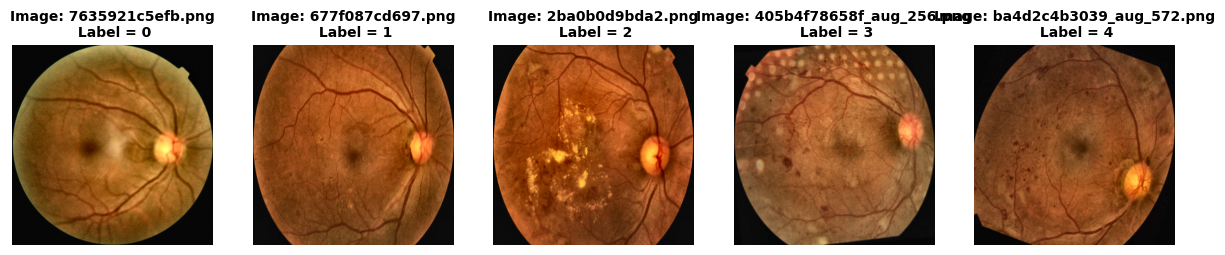

In [17]:
train_df = pd.DataFrame({'id_code': paths, 'diagnosis': labels})
train_df['diagnosis'] = train_df['diagnosis'].astype(int)

fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()

    # The 'id_code' column already contains the full path including the extension.
    # So, we can directly use image_name as the path.
    image_path = image_name

    X = cv2.imread(image_path)
    X=image_resize(X)

    if X is None:
        print(f"Warning: Could not read image at {image_path}. Skipping plot for this sample.")
        continue
    ax[i].set_title(f"Image: {os.path.basename(image_name)}\n Label = {sample['diagnosis'].item()}",
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [18]:
val_df['diagnosis']=val_df['diagnosis'].astype(int)
train_df['diagnosis']=train_df['diagnosis'].astype(int)
val_df['full_path'] = val_df['id_code'].apply(lambda x: os.path.join(test_images, f"{x}.png"))


In [19]:
from numpy.random import shuffle
train_datagen = ImageDataGenerator(preprocessing_function=image_resize,
                                   )

val_datagen=ImageDataGenerator(preprocessing_function=image_resize)


train_gen = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='id_code',
                                                    y_col='diagnosis',
                                                    directory = None,
                                                    target_size=(IM_SIZE,IM_SIZE),
                                                    batch_size=4,
                                                    class_mode='raw',
                                                    shuffle=True)


val_gen = val_datagen.flow_from_dataframe(val_df,
                                                  x_col='full_path',
                                                  y_col='diagnosis',
                                                  directory = None,
                                                  target_size=(IM_SIZE,IM_SIZE),
                                                  batch_size=4,
                                                  class_mode='raw',
                                                  shuffle=False)

Found 4394 validated image filenames.
Found 366 validated image filenames.


## QWK

In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score

class QWKRegressionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, model_name='best_model.keras', thresholds=None):
        super().__init__()
        self.val_gen = val_gen
        self.model_name = model_name
        self.best_kappa = -1

        # Default thresholds for 5 classes (0,1,2,3,4)
        self.thresholds = thresholds if thresholds is not None else [0.5, 1.5, 2.5, 3.5]

        # Ensure shuffle is off for the validation generator
        if hasattr(val_gen, 'shuffle'):
            if val_gen.shuffle:
                print("⚠️ Warning: validation generator should have shuffle=False for accurate QWK calculation.")

        # Extract labels safely
        self.y_true = np.array(val_gen.labels)

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()

        # Get continuous predictions
        y_pred_continuous = self.model.predict(self.val_gen, verbose=0).flatten()

        # Use digitize for cleaner thresholding
        # np.digitize returns the index of the bin the value belongs to
        y_pred_discrete = np.digitize(y_pred_continuous, self.thresholds)

        # Clip to ensure valid range (e.g., 0 to 4)
        y_pred_discrete = np.clip(y_pred_discrete, 0, len(self.thresholds))

        # Calculate Score
        val_kappa = cohen_kappa_score(self.y_true, y_pred_discrete, weights='quadratic')

        print(f"\nEpoch {epoch + 1}: val_qwk: {val_kappa:.4f}")

        # Save if best
        if val_kappa > self.best_kappa:
            self.best_kappa = val_kappa
            self.model.save(self.model_name)
            print(f"✅ Saved new best model with QWK: {val_kappa:.4f}")

## The Models

## EfficientNetB5->0.91qwk

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers, models

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable= True

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

In [ ]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'] )


In [ ]:
def schedule_fn(epoch, lr):
    start_lr = 0.0001
    end_lr = 1e-5
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [ ]:
qwk=QWKRegressionCallback(val_gen,thresholds= [0.7, 1.5, 2.5, 3.5])
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 0.5239 - mae: 0.8669
Epoch 1: val_qwk: 0.7925
✅ Saved new best model with QWK: 0.7925
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 878s 599ms/step - loss: 0.5238 - mae: 0.8667 - learning_rate: 1.0000e-04
Epoch 2/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - loss: 0.2289 - mae: 0.5089
Epoch 2: val_qwk: 0.8576
✅ Saved new best model with QWK: 0.8576
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 529s 481ms/step - loss: 0.2288 - mae: 0.5088 - learning_rate: 8.9125e-05
Epoch 3/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - loss: 0.1332 - mae: 0.3711
Epoch 3: val_qwk: 0.8039
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 524s 477ms/step - loss: 0.1332 - mae: 0.3711 - learning_rate: 7.9433e-05
Epoch 4/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - loss: 0.0897 - mae: 0.2972
Epoch 4: val_qwk: 0.8570
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 556s 506ms/step - loss: 0.0897 - mae: 0.2971 - learning_rate: 7.0795e-05
Epoch 5/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 

## Evaluate EfB5

In [ ]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

In [ ]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.imshow(attention_map_resized, cmap='jet', alpha=0.3)
plt.title('Sample Image with Attention Heatmap')
plt.axis('off')
plt.colorbar(label='Attention Weight')
plt.show()

## InceptionV3->0.91qwk

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))
print("Pre-trained InceptionV3 model loaded successfully.")
base_model.trainable= True

Pre-trained InceptionV3 model loaded successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Multiply

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)



In [ ]:
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'] )


In [ ]:
def schedule_fn(epoch, lr):
    start_lr = 0.0001
    end_lr = 1e-5
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [ ]:
qwk=QWKRegressionCallback(val_gen,thresholds= [0.7, 1.5, 2.5, 3.5])
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.4532 - mae: 0.7983
Epoch 1: val_qwk: 0.8338
✅ Saved new best model with QWK: 0.8338
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 676s 524ms/step - loss: 0.4531 - mae: 0.7982 - learning_rate: 1.0000e-04
Epoch 2/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.2127 - mae: 0.4871
Epoch 2: val_qwk: 0.8749
✅ Saved new best model with QWK: 0.8749
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 517s 470ms/step - loss: 0.2127 - mae: 0.4871 - learning_rate: 8.9125e-05
Epoch 3/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.1552 - mae: 0.4039
Epoch 3: val_qwk: 0.8950
✅ Saved new best model with QWK: 0.8950
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 515s 469ms/step - loss: 0.1552 - mae: 0.4039 - learning_rate: 7.9433e-05
Epoch 4/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.1145 - mae: 0.3439
Epoch 4: val_qwk: 0.8742
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 512s 466ms/step - loss: 0.1145 - mae: 0.3439 - learning_rate: 7.0795e-05
Epoch 5/30
1099/1099 ━━━

## EfB70

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Reshape, Multiply

base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

base_model.trainable= True

x = base_model.output

ap = tf.keras.layers.GlobalAveragePooling2D()(x)

attention_probs = tf.keras.layers.Dense(64, activation='relu')(ap)

attention_probs = tf.keras.layers.Dense(2048, activation='sigmoid')(attention_probs)

attention_probs = Reshape((1, 1, 2048))(attention_probs)

attended_output = Multiply()([x, attention_probs])

x = tf.keras.layers.GlobalAveragePooling2D()(attended_output)

x = tf.keras.layers.Dense(256, activation='relu')(x)

output_layer = tf.keras.layers.Dense(1, activation='linear')(x)
model=tf.keras.Model(inputs=base_model.input,outputs=output_layer)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4),loss=tf.keras.losses.Huber(delta=1.0), metrics=['mae'] )

In [22]:
def schedule_fn(epoch, lr):
    start_lr = 0.0001
    end_lr = 1e-5
    total_epochs = 20

    if epoch < total_epochs:
        gamma = (end_lr / start_lr) ** (1 / total_epochs)
        return start_lr * (gamma ** epoch)
    else:
        return end_lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_fn)

In [25]:
qwk=QWKRegressionCallback(val_gen,thresholds= [0.7, 1.5, 2.5, 3.5])
history=model.fit(train_gen,epochs=30,callbacks=[qwk,lr_scheduler])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 0.5351 - mae: 0.8823
Epoch 1: val_qwk: 0.8344
✅ Saved new best model with QWK: 0.8344
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 891s 617ms/step - loss: 0.5350 - mae: 0.8821 - learning_rate: 1.0000e-04
Epoch 2/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.2199 - mae: 0.4929
Epoch 2: val_qwk: 0.8963
✅ Saved new best model with QWK: 0.8963
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 543s 494ms/step - loss: 0.2198 - mae: 0.4929 - learning_rate: 8.9125e-05
Epoch 3/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 0.1307 - mae: 0.3655
Epoch 3: val_qwk: 0.8621
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 533s 485ms/step - loss: 0.1307 - mae: 0.3655 - learning_rate: 7.9433e-05
Epoch 4/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 0.0882 - mae: 0.2972
Epoch 4: val_qwk: 0.8867
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 533s 484ms/step - loss: 0.0882 - mae: 0.2972 - learning_rate: 7.0795e-05
Epoch 5/30
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 

KeyboardInterrupt: 

In [29]:
images, labels = next(val_gen)
sample_image = images[0]
sample_label = labels[0]
sample_image_processed = np.expand_dims(sample_image, axis=0)

print(f"Sample image shape: {sample_image.shape}")
print(f"Sample image processed shape for model input: {sample_image_processed.shape}")
print(f"Sample label: {sample_label}")

Sample image shape: (455, 455, 3)
Sample image processed shape for model input: (1, 455, 455, 3)
Sample label: 0


In [30]:
from scipy.ndimage import zoom
attention_model = Model(inputs=base_model.input, outputs=[attention_probs, output_layer])


attention_map_raw, predictions = attention_model.predict(sample_image_processed)

attention_output_model = Model(inputs=base_model.input, outputs=attended_output)
attended_feature_map = attention_output_model.predict(sample_image_processed)

attention_map = np.mean(attended_feature_map, axis=-1)
attention_map = attention_map[0]


scale_factor_h = sample_image.shape[0] / attention_map.shape[0]
scale_factor_w = sample_image.shape[1] / attention_map.shape[1]

attention_map_resized = zoom(attention_map, (scale_factor_h, scale_factor_w), order=1)

print(f"Raw attention map shape: {attention_map.shape}")
print(f"Resized attention map shape: {attention_map_resized.shape}")
print(f"Model prediction for sample image: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Raw attention map shape: (15, 15)
Resized attention map shape: (455, 455)
Model prediction for sample image: [[-0.06355137]]
